# P300 with muse - Cats & Dogs

I was interested in knowing whether it was possible to observe a P300 with a Muse 2016 EEG headset.
EEG channels on the Muse are not positioned ideally for P300. However, EEG potentials diffuses on the whole scalp and it is very likely that we will be able to observe a P300 ERP even if the electrode are far away from the region of interest. The real question is **How reliable will this observation be?**.

So I designed a simple [Oddball Paradigm](https://en.wikipedia.org/wiki/Oddball_paradigm) using visual stimulus. I used two type of stimulus, frequency stimulus consisting in a grating with vertical stripes, and rare (target) stimulus with horizontal stripes. 
The task was to count the number of times I saw the stimulus with horizontal stripes.

Stimulus were presented for 200ms at an interval of 600ms with a random jitter of +- 100ms.

I recorded 6 runs of 2 minutes, for a total count of 960 Non-target and 184 Target stimulus.

### Record your own data

To record your own data, you need a muse 2016 headset.
Use the script `muse-lsl.py` to stream data from the muse, then launch the following two scripts in another terminal

`python stimulus_presentation/generate_Visual_P300.py -d 120 & python lsl-record.py -d 120`

this will display stimulations and record data for 2 minutes.
you can do as many run as you wish, but 5 runs (10 minutes) is ideal.

In [1]:
import sys
from collections import OrderedDict

from mne import create_info, concatenate_raws
from mne.io import RawArray
from mne.channels import read_montage

import pandas as pd
import numpy as np

from glob import glob
import seaborn as sns
from matplotlib import pyplot as plt

sys.path.append('../muse_lsl/muse')
import utils

%matplotlib inline

## Read data and convert them in MNE objects

Data is read from this folder's data/visual/P300 folder. Data will come from folders with the model `subject {subject}` and `session {session}`

Data is saved in csv file for more convenience. Then we will convert them into MNE data object so we can pre-process and epoch them

In [21]:
subject = 2
session = 2
raw = utils.load_data('visual/P300', sfreq=256., 
                      subject_nb=subject, session_nb=session, 
                      ch_ind=[0, 1, 2, 3])

Creating RawArray with float64 data, n_channels=5, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.


## Power Spectrum

Effective window size : 8.000 (s)


/home/dano/anaconda3/lib/python3.6/site-packages/mne/viz/raw.py:614: DeprecationWarning: In version 0.15 average will default to False and spatial_colors will default to True.
  'spatial_colors will default to True.', DeprecationWarning)


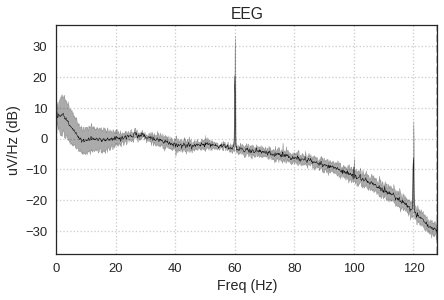

In [22]:
raw.plot_psd(tmax=np.inf);

We can clearly see the 60Hz (and its first harmonic) in the signal.

## Filtering

We filter data between 1 and 30 Hz

In [23]:
raw.filter(1,30, method='iir')

Setting up band-pass filter from 1 - 30 Hz


<RawArray  |  None, n_channels x n_times : 5 x 92196 (360.1 sec), ~3.5 MB, data loaded>

## Epoching

Here we epoch data for -100ms to 800ms after the stimulus. No baseline correction is needed (signal is bandpass filtered) and we reject every epochs where the signal exceed 100uV. This concerns mainly blinks.


In [24]:
from mne import Epochs, find_events

#TODO: print sample drop %
events = find_events(raw)
event_id = {'Non-Target': 1, 'Target': 2}

epochs = Epochs(raw, events=events, event_id=event_id, tmin=-0.1, tmax=0.8, baseline=None,
                reject={'eeg': 100e-6}, preload=True, verbose=False, picks=[0,1,2,3], add_eeg_ref=False)
epochs

586 events found
Events id: [1 2]


<Epochs  |  n_events : 568 (all good), tmin : -0.1015625 (s), tmax : 0.80078125 (s), baseline : None, ~4.0 MB, data loaded,
 'Non-Target': 473, 'Target': 95>

## Epoch average

Now we can plot the average ERP for both conditions, and see if there is something

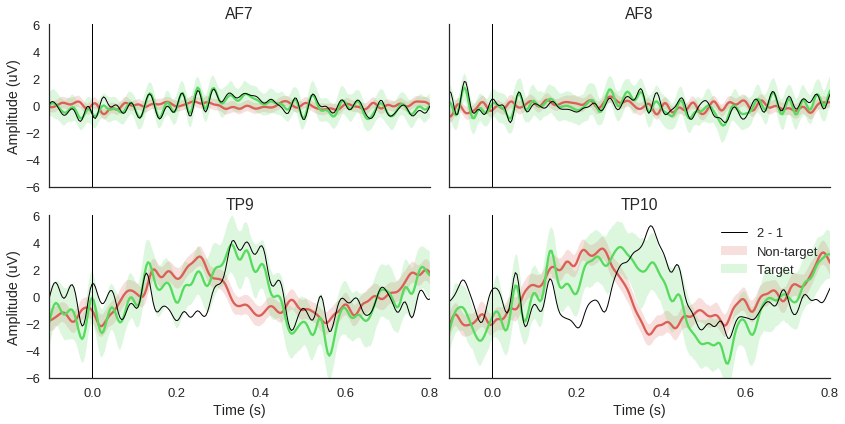

In [25]:
conditions = OrderedDict()
conditions['Non-target'] = [1]
conditions['Target'] = [2]

fig, ax = utils.plot_conditions(epochs, conditions=conditions, 
                                ci=97.5, n_boot=1000, title='',
                                diff_waveform=(1, 2))

As we can see, there is a clear and identifiable P300 on electrodes TP9 and TP10. We can see a little bit of activity on AF8 but not on AF7. 

The reference of the Muse headset is on FPz, very close to the two frontal electrode. 
This means that unless there is a left-right local gradient of the potential on the forehead, it is very unlikely that we will observe anything on these two electrodes.
This also means that any potential local to the reference will be projected negatively on the TP electrodes. This is why you will only see blinks on the TP electrodes and not on frontal electrodes.

Anyway, here there is no doubt about the presence of a P300 potential.

## Decoding

By averaging the epochs, we can clearly identify an ERP. However this does not tell us anything about the SNR of the P300. I like using a classification pipeline to get a sense of the strength of the P300 response on a single trial basis.

Here we will use 4 different pipelines :
- **Vect + LR** :  Vectorization of the trial + Logistic Regression. This can be considered as the standard decoding pipeline in MEG / EEG.
- **Vect + RegLDA** :  Vectorization of the trial + Regularized LDA. This one is very utilized in P300 BCI. It can outperform the previous one but can become unusable if the number of dimension is too high.
- **Xdawn + RegLDA** :  Xdawn spatial filtering + Vectorization of the trial + Regularized LDA.
- **ERPCov + TS**: ErpCovariance + Tangent space mapping. One of my favorite Riemannian geometry based pipeline.
- **ERPCov + MDM**: ErpCovariance + MDM. A very simple, yet effective (for low channel count), Riemannian geometry classifier.

Evaluation is done in cross-validation, with AUC as metric (AUC is probably the best metric for binary and unbalanced classification problem)

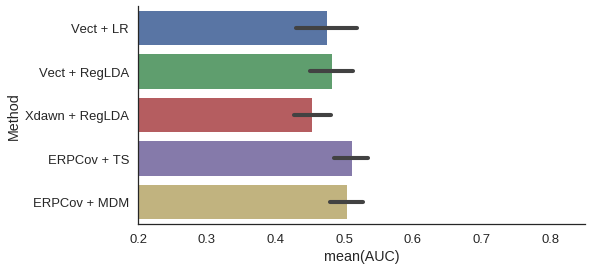

In [14]:
from sklearn.pipeline import make_pipeline

from mne.decoding import Vectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit

from pyriemann.estimation import ERPCovariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import MDM
from pyriemann.spatialfilters import Xdawn

from collections import OrderedDict

clfs = OrderedDict()

clfs['Vect + LR'] = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression())
clfs['Vect + RegLDA'] = make_pipeline(Vectorizer(), LDA(shrinkage='auto', solver='eigen'))
clfs['Xdawn + RegLDA'] = make_pipeline(Xdawn(2, classes=[1]), Vectorizer(), LDA(shrinkage='auto', solver='eigen'))
clfs['ERPCov + TS'] = make_pipeline(ERPCovariances(), TangentSpace(), LogisticRegression())
clfs['ERPCov + MDM'] = make_pipeline(ERPCovariances(), MDM())

# format data
epochs.pick_types(eeg=True)
X = epochs.get_data() * 1e6
times = epochs.times
y = epochs.events[:, -1]

# define cross validation 
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.25, random_state=42)

# run cross validation for each pipeline
auc = []
methods = []
for m in clfs:
    res = cross_val_score(clfs[m], X, y==2, scoring='roc_auc', cv=cv, n_jobs=-1)
    auc.extend(res)
    methods.extend([m]*len(res))
    
results = pd.DataFrame(data=auc, columns=['AUC'])
results['Method'] = methods

plt.figure(figsize=[8,4])
sns.barplot(data=results, x='AUC', y='Method')
plt.xlim(0.2, 0.85)
sns.despine()

The best pipeline is **ERPCov + MDM** and yield an average AUC of 0.77. This AUC can be considered as good.

# Conclusion

Based on this initial results, we can say that it is possible to observe a P300 with the muse headset.
Considering the AUC of 0.8, this can even be used for some BCI application, even if one should not expect outstanding results.